# Lab -  Anomaly Detection

**Objectives**: implement Gaussian distribution model to detect anomalous behavior in server computers. 

While the servers were operating, data regarding the through-put (mb/s) and latency (ms) of response of each server were collected. Vast majority of the servers were acting normal but a few servers were acting anomalously.
On that dataset you will ﬁt a Gaussian distribution of the server features and then identify which are the anomalous samples. 

In [1]:
# Loading relevant libraries
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=RuntimeWarning)

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import matplotlib
%matplotlib inline

### Load Data 
Load data from file ex9data.mat and get train, test and validation data.

In [6]:
data = loadmat('ex9data.mat')

Xtrain = data['Xtrain']
Xtest = data['Xtest']
Xval = data['Xval']
yval = data['yval']

#What is the shape of each variable, what is the meaning of the rows and the columns ?
string = 'Xtrain shape: {0} \nXtest shape: {1} \nXval shape: {2} \nyval shape: {3}'
print(string.format(Xtrain.shape, Xtest.shape, Xval.shape, yval.shape))
#How many are the normal (label 0) and the abnormal (label 1) validation samples ?
string = 'Normal samples: {0} \nAbnormal samples: {1}'
print(string.format((yval==0).sum(), (yval==1).sum()))

Xtrain shape: (300, 2) 
Xtest shape: (307, 2) 
Xval shape: (307, 2) 
yval shape: (307, 1)
Normal samples: 298 
Abnormal samples: 9


### Plot data

<img src="images/im1.png" style="width:600px;height:300px;">
<caption><center> **Fig. 1** : **Latency versus Throughput** </center></caption>

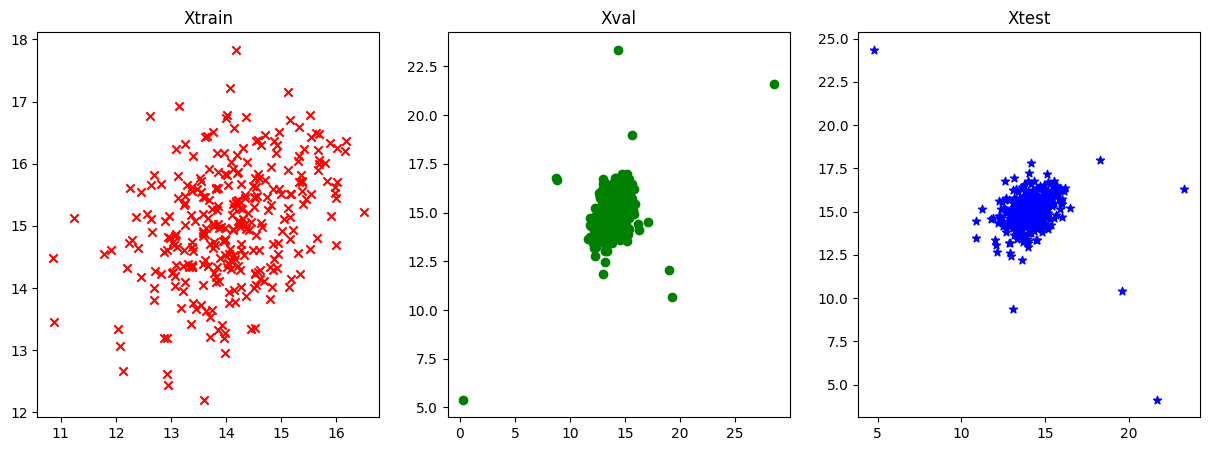

In [7]:
# Plot the scater plots of (Xtrain,Xval, Xtest) and get figure similar to Fig. 1. 
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.scatter(Xtrain[:,0],Xtrain[:,1],c='r',marker='x')
plt.title('Xtrain')
plt.subplot(132)
plt.scatter(Xval[:,0],Xval[:,1],c='g',marker='o')
plt.title('Xval')
plt.subplot(133)
plt.scatter(Xtest[:,0],Xtest[:,1],c='b',marker='*')
plt.title('Xtest')
plt.show()


### Plot Data

<img src="images/im2.png" style="width:300px;height:250px;">
<caption><center> **Fig. 2** : **Data distribution** </center></caption>

(array([ 2.,  2.,  1.,  6.,  8., 11., 18., 34., 34., 33., 33., 32., 34.,
        14., 19., 10.,  6.,  2.,  0.,  1.]),
 array([12.20295199, 12.48448036, 12.76600874, 13.04753711, 13.32906548,
        13.61059386, 13.89212223, 14.1736506 , 14.45517898, 14.73670735,
        15.01823572, 15.2997641 , 15.58129247, 15.86282084, 16.14434922,
        16.42587759, 16.70740596, 16.98893434, 17.27046271, 17.55199108,
        17.83351945]),
 <BarContainer object of 20 artists>)

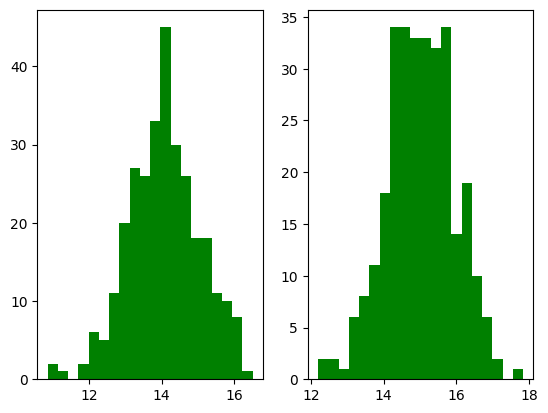

In [32]:
# Plot the histograms of each feature and get figure simular to Fig.2.
plt.subplot(121)
plt.hist(Xtrain[:,0],bins=20,color='g')
plt.subplot(122)
plt.hist(Xtrain[:,1],bins=20,color='g')

### Gaussian Distribution

To perform anomaly detection, you first need to fit a model only to the normal data.

Given a training set {x(1), …, x(m)} (where x(i) ∈ R^n, here n = 2), you want to estimate the Gaussian distribution for each feature (i = 1 . . . n), i.e. find mean and variance (mu, sigma²). 

Gaussian distribution:  $p(x;\mu,\sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{\frac{(x-\mu)^2}{2\sigma^2}}$

mean:  $\mu_i = \frac{1}{m}\sum^m_{j=1}x^{(j)}$

variance:  $\sigma^2_i = \frac{1}{m}\sum^m_{j=1}(x^{(j)} - \mu_j)^2$

In [35]:
def estimateGaussian(X):
    """
     This function estimates the parameters of a Gaussian distribution using the data in X
    """
    m= X.shape[0]
    
    #compute the mean of X per column
    mu = np.mean(X,axis=0)
     
    # compute variance =sigma^2 of X per column
    sigma2 = np.var(X,axis=0)
    
    return mu,sigma2

In [36]:
# Estimate mean and variance for the Gaussian model of NORMAL data (Xtrain)
# ANSWER: mu =  [14.06411334 15.02441479] ; sigma2 = [0.93434723 0.8506542 ]

mu, sigma2 = estimateGaussian(Xtrain)
print('mu = ',mu)
print('sigma2 =',sigma2)


mu =  [14.06411334 15.02441479]
sigma2 = [0.93434723 0.8506542 ]


### Multivariate Gaussian Distribution

Inside function *multivariateGaussian*, $\sigma^2$ vector is converted into the covariance matrix  $\Sigma$.  Assuming the features are independent, each element of vector $\sigma^2$ will be on the diagonal of matrix $\Sigma$ and the rest of the elements are 0. 

The formula for the multivariate probability distribution is:

$p(x;\mu,\Sigma) = \frac{1}{(2\pi)^{n/2}|\Sigma|^{1/2}} exp(-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu))$

In [37]:
#Complete the function
def multivariateGaussian(X, mu, sigma2):
    """
    Computes the probability density function of the multivariate Gaussian distribution.
    """
    n= X.shape[1]
    sigma_diag=np.diag(sigma2)  #Diagonal matrix (features are independent !!!!)
    X = X - mu.T
    p = 1/((2*np.pi)**(n/2)*(np.linalg.det(sigma_diag)**0.5))* np.exp(-0.5* np.sum(X @ np.linalg.pinv(sigma_diag) * X,axis=1))
    return p

### Select the threshold $\epsilon$  that will flag an example as anomaly

Dataset is highly unbalanced, accuracy is not a good metrics, therefore F1 score is used to determine the best epsilon. Best parameters are the ones in which F1 score is maximum.

Predict anomaly if pval<epsilon !

Note: try-except block is used to excape zero division when compute precision and recall.

In [40]:
#Complete the function
def selectThreshold(yval, pval):
    """
    Find the best threshold (epsilon) to separate normal/anomalous samples
    Best epsilon is when F1 score is max 
    """
    best_epi = 0
    best_F1 = 0
    
    #range of threshold values to decide the best one. 
    stepsize = (max(pval) -min(pval))/1000
    epi_range = np.arange(pval.min(),pval.max(),stepsize)
    for epi in epi_range:
        
        #predictions is a binary vector
        predictions = (pval<epi)[:,np.newaxis]
        
        #compute true positive
        tp = len(np.where((predictions==1) & (yval==1))[0])
        
        #compute false positive
        fp = len(np.where((predictions==1) & (yval==0))[0])
        
        #compute false negative 
        fn = len(np.where((predictions==0) & (yval==1))[0])
        
        try:
        # compute precision
            prec = float(tp)/(tp+fp)
            
            #compute recall
            rec = float(tp)/(tp+fn)
            
            #compute  F1
            F1 = 2*prec*rec/(prec+rec)
        
            if F1 > best_F1:
                best_F1 =F1
                best_epi = epi
            
        except ZeroDivisionError:
                print('Warning dividing by zero!!')  
        
    return best_epi, best_F1

In [41]:
# Apply multivariateGaussian to compute the probability of the examples in Xval. 
pval = multivariateGaussian(Xval, mu, sigma2)

#Apply selectThreshold to compute the best epsilon and best F1 with the validation data
epsilon, F1 = selectThreshold(yval, pval)

# What is the Best epsilon ?  => ANSWER: 0.00018
print('Best epsilon = ',epsilon)
# What is the Best F1 ? => ANSWER: 0.8235
print('Best F1 = ',F1)

Warning dividing by zero!!
Best epsilon =  0.00017841159895769934
Best F1 =  0.823529411764706


**findIndices** returns the indices of faulty servers. This gives a binary vector where 1 means anomaly and 0 means normal.

In [42]:
def findIndices(binVec):
    l = []
    for i in range(len(binVec)):
        if binVec[i] == 1:
            l.append(i)
    return l

In [43]:
# Apply multivariateGaussian to compute the probability of the examples in Xtest
p = multivariateGaussian(Xtest, mu, sigma2)

outl = (p < epsilon)
listOfOutliers=findIndices(outl)

#How many are the Outliers => #ANSWER: 6 
print('Number of Outliers = ',len(listOfOutliers))
#print them
print('Outliers indices = ',listOfOutliers)



Number of Outliers =  6
Outliers indices =  [300, 301, 303, 304, 305, 306]


### Visualize the anomalies

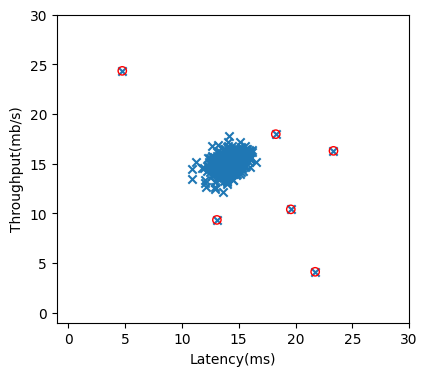

In [44]:
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.scatter(Xtest[:, 0], Xtest[:, 1], marker = "x")
plt.xlabel('Latency(ms)')
plt.ylabel('Throughput(mb/s)')
plt.scatter(Xtest[listOfOutliers,0], Xtest[listOfOutliers, 1], facecolors = 'none', edgecolors = 'r')
plt.xlim(-1,30)
plt.ylim(-1,30)
plt.show()